# Paramètres <br/>
$D$ la demande du client <br/>
$PPA_t$ la production du PPA (de prix $p_{PPA} = 20 €/ MWh$) <br/>
$p_t$ le prix de l'éléricité sur le marché <br/>
$e_{bat}$ l'éfficité de la batterie <br/>
$c_{bat}$ la capacité de la batterie <br/>
$f_{bat}$ le flux maximal de la batterie <br/>
$e_{elec}$ l'éfficité de l'électrolyseur <br/>
$c_{elec}$ la capacit_é de l'électrolyseur <br/>
$c_{tank}$ la capacité du réservoir <br/>

# Variables <br/>
$\text{charge}_t$ la charge de la batterie à l'heure $t$ (en MWh)<br/>
$\text{prod}_t$ la production de l'électrolyseur à l'heure $t$ (en kg $H_2$)<br/>
$\text{stock}_t$ le stock d'hydrogène dans le reservoir à l'heure $t$ (en kg $H_2$)<br/>
$\text{elec}_t$ la consommation d'élécricité venant de la grille à l'heure $t$ (en MWh) <br/>
$\text{consPPA}_t$ la consommation d'élécricité venant du PPA à l'heure $t$ (en MWh) <br/>

# Contraintes <br/>

Satisfaction de la demande du client : <br/>
$\forall t \in [|1, T|], \text{prod}_t + \text{stock}_t = D_t + \text{stock}_{t+1}$ <br/>
Consomation d'élécricité : <br/>
$\forall t \in [|1, T|], \text{elec}_t + \text{consPPA}_t + e_{bat} \times \text{charge}_t = e_{elec} \times \text{prod}_t + \text{charge}_{t+1}$ <br/>
Contraintes de capacité : <br/>
$\forall t \in [|1, T|], \text{charge}_t \leq c_{bat}$ <br/>
$\forall t \in [|1, T|], \text{prod}_t \times e_{elec} \leq c_{elec} $ <br/>
$\forall t \in [|1, T|], \text{stock}_t \leq c_{tank} $ <br/>
$\forall t \in [|1, T|], \text{consPPA}_t \leq PPA_t $ <br/>
Contraintes de flux : <br/>
$\forall t \in [|1, T|], |\text{charge}_t - \text{charge}_{t+1}| \leq f_{bat} $ <br/>

# Objectif <br/>

Minimiser le coût de l'élécricité : <br/>
$\min \sum_{t=1}^{T} p_t \times \text{elec}_t + p_{PPA} \times \text{consPPA}_t$

In [5]:
from pulp import *
import matplotlib.pyplot as plt
import solver

In [6]:
D = 1000 # Kg of H2
PPA = [50] * 18 + [40, 30, 20, 10, 0, 50] # Mwh
PPPA = 20 # € / MWh
Pt = [20.79, 17.41, 16.24, 11.9, 9.77, 15.88, 24.88, 29.7, 35.01, 33.95, 29.9, 29.03] # € / MWh
Pt += [27.07, 26.43, 27.53, 29.05, 31.42, 39.92, 41.3, 41.51, 39.75, 30.13, 30.36, 32.4]

ebat = 0.9
cbat = 400 # MWh
fbat = 100 # MW

eelec = 0.050 # Mwh / Kg
celec = 1000 # MW

ctank = 500 # Kg

T = len(PPA)

In [7]:
output = solver.solve(D, PPA, PPPA, Pt, ebat, cbat, fbat, eelec, celec, ctank)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/nicolas/.local/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/34c10c531653431e9ed0783568d20301-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/34c10c531653431e9ed0783568d20301-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 249 COLUMNS
At line 734 RHS
At line 979 BOUNDS
At line 980 ENDATA
Problem MODEL has 244 rows, 170 columns and 436 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 20 (-224) rows, 43 (-127) columns and 62 (-374) elements
0  Obj 27196.65 Dual inf 671.32998 (24)
21  Obj 43453.417
Optimal - objective value 43453.417
After Postsolve, objective 43453.417, infeasibilities - dual 34.4755 (2), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 43453.417
Optimal - objective value 43453.417
Optimal objective 43453.41699 - 21

In [8]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
consPPA_out = output["consPPA"]

Text(0.5, 1.0, 'H2 production and stock, constant demand of 1000 Kg')

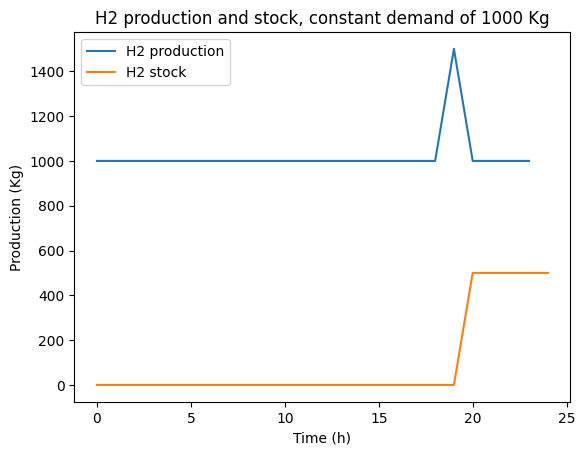

In [9]:
# Plot the production
fig, ax = plt.subplots()

ax.plot(range(T), prod_out, label = "H2 production")
ax.plot(range(T+1), stock_out, label = "H2 stock")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Production (Kg)")
ax.set_title(f"H2 production and stock, constant demand of {D} Kg")

Text(0.5, 1.0, 'Prices')

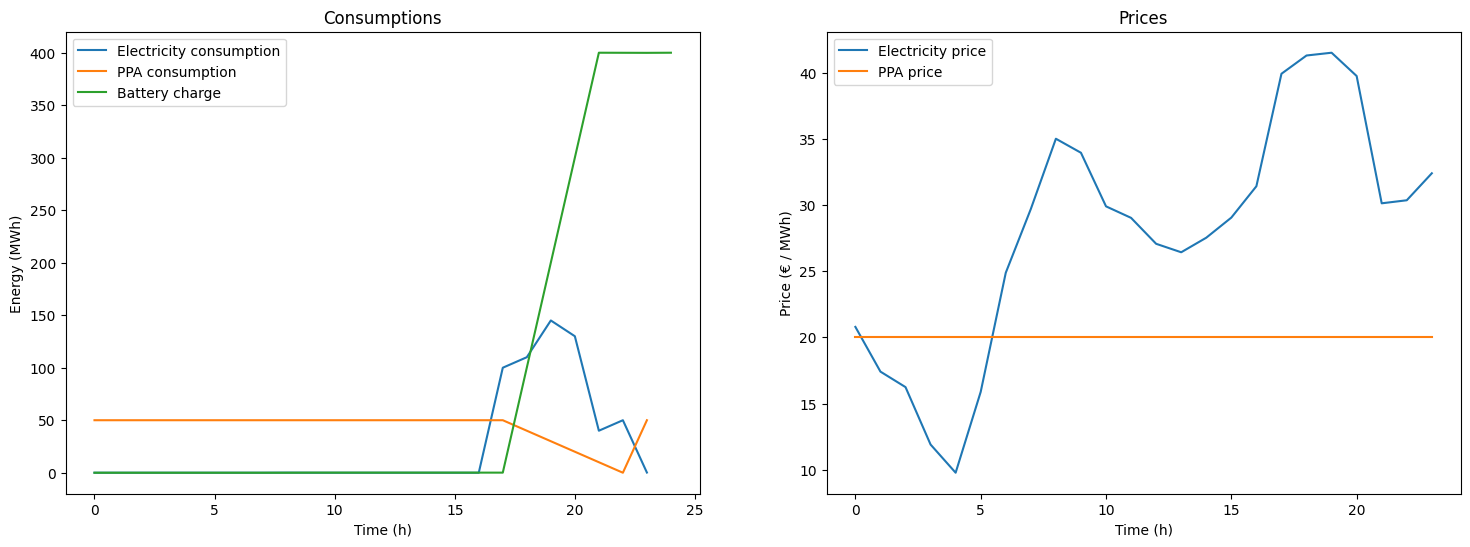

In [10]:
fig = plt.figure(figsize = (18, 6))
# Plot the consumptions
ax = fig.add_subplot(121)
ax.plot(range(T), elec_out, label="Electricity consumption")
ax.plot(range(T), consPPA_out, label="PPA consumption")
ax.plot(range(T+1), charge_out, label="Battery charge")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Energy (MWh)")
ax.set_title("Consumptions")
# Plot the prices
ax2 = fig.add_subplot(122)
ax2.plot(range(T), Pt, label="Electricity price")
ax2.plot(range(T), [PPPA] * T, label="PPA price")
ax2.legend()
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Price (€ / MWh)")
ax2.set_title("Prices")

